In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Resizing, Rescaling, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import cv2
import pandas as pd

/Users/jonathanhaller/miniforge3/envs/tf_mac_env/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Laden der Bilder und Label
Die Bilder werden als Graustufenbilder in dem Feature-Vektor gespeichert. Dieser hat die Form `(Anzahl Bilder, Pixel_x, Pixel_y, Farbkanäle(1 für Graustufe, 3 für RGB)`.

Die Daten werden dann in Trainings-, Validierungs- und Testdatensätze aufgeteilt.

In [91]:
# Einladen der Bilder
# Die Bilder werden hierbei auf von einer Größe von 256x256 Pixeln auf 196x196 Pixel verkleinert

images_list = glob(r"./data/256_res/*.png")
image_names = [os.path.basename(file) for file in glob('./data/256_res/*.png')]
features = np.ndarray((len(images_list), 196, 196, 3))
for count, image in enumerate(images_list):
    im = cv2.imread(image)
    im = cv2.resize(im, (196,196))
    colored_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    features[count,:,:] = colored_image

features = features[:,:,:]
df_labels = pd.read_csv("./LabelingApp/Labels.csv")
df_labels = pd.get_dummies(df_labels, columns=["label"])

labels = np.ndarray((df_labels.shape[0], df_labels.shape[1]-1))
for im_count, image in enumerate(image_names):
    labels[im_count, :] = df_labels[df_labels["file"] == image].iloc[:, 1:].values
        
[X_train, X_test, y_train, y_test] = train_test_split(features, labels, test_size=0.2, random_state=41)
[X_train, X_val, y_train, y_val] = train_test_split(X_train, y_train, test_size=0.3, random_state=41)

In [93]:
print("labels_shape: ", labels.shape)
print("features_shape: ", features.shape)
print("Train_Data_shape: ", y_train.shape)
print("Val_Data_shape: ", y_val.shape)
print("Test_Data_shape: ", y_test.shape)

(1449, 15)

<BarContainer object of 11 artists>

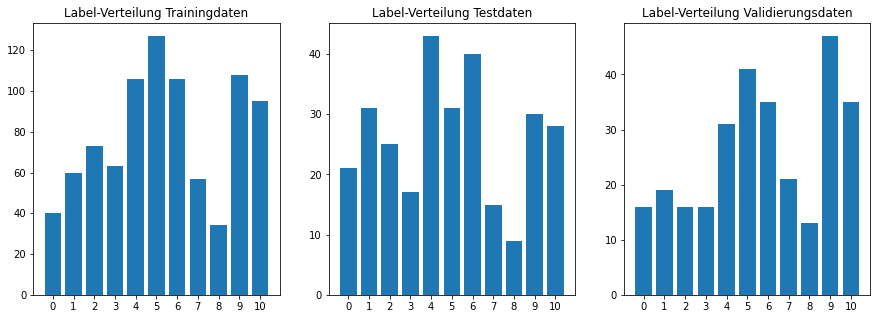

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (15,5))
unique_values_train, value_count_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
unique_values_test, value_count_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
unique_values_val, value_count_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)
values_all, values_count_all = np.unique(np.argmax(labels, axis=1), return_counts=True)

axs[0].set_xticks(np.unique(np.argmax(y_train, axis=1)))
axs[1].set_xticks(np.unique(np.argmax(y_test, axis=1)))
axs[2].set_xticks(np.unique(np.argmax(y_val, axis=1)))
axs[3].set_xticks(np.unique(np.argmax(labels, axis=1)))

axs[0].set_title("Label-Verteilung Trainingdaten")
axs[1].set_title("Label-Verteilung Testdaten")
axs[2].set_title("Label-Verteilung Validierungsdaten")
axs[3].set_title("Label-Verteilung Alle Daten")

axs[0].bar(unique_values_train, value_count_train)
axs[1].bar(unique_values_test, value_count_test)
axs[2].bar(unique_values_val, value_count_val)
axs[3].bar(values_all, values_count_all)

## Erstellung von Schichten für Preprocessing
`resize_and_rescale` ist eine Schicht mit der die Bilder auf 256x256 skaliert werden und die Pixel-Werte auf den Wertebereich von (-1, 1) skaliert werden

`data_augmentation` sorgt dafür, dass die Bilder noch über die horizontale und vertikale Achse gespiegelt werden um mehr Daten zu generieren.

In [70]:
resize_and_rescale = Sequential([
  Rescaling(1./127.5, offset=-1, input_shape=(196,196,3)) #skaliert Bildwerte in einem Bereich von (-1, 1)
  ])

data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical")])

model_saving = tf.keras.callbacks.ModelCheckpoint("./models/CNN_XX.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
callbacks = [model_saving, early_stopping]

## Erstellung des CNNs

In [71]:
model = Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(16, activation='relu', kernel_size=5, padding= "same"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, activation='relu', kernel_size=3, padding= "same"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, activation='relu', kernel_size=1, padding= "same"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, activation='relu', kernel_size=3, padding= "same"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, activation='relu', kernel_size=3, padding= "same", activity_regularizer=l2(0.0008)))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, activation='relu', kernel_size=3, padding= "same", activity_regularizer=l2(0.0058)))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.45))

model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

## Training des CNNs

In [72]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size = 38, callbacks=[callbacks], shuffle=True)

Epoch 1/10
28/28 [==============================] - 4s 122ms/step - loss: 5.2101 - accuracy: 0.1519 - val_loss: 2.8311 - val_accuracy: 0.2138
Epoch 2/10
28/28 [==============================] - 3s 103ms/step - loss: 2.1854 - accuracy: 0.3049 - val_loss: 1.9402 - val_accuracy: 0.2655
Epoch 3/10
28/28 [==============================] - 3s 103ms/step - loss: 1.7494 - accuracy: 0.4131 - val_loss: 1.7958 - val_accuracy: 0.3276
Epoch 4/10
28/28 [==============================] - 3s 102ms/step - loss: 1.5301 - accuracy: 0.4925 - val_loss: 1.7613 - val_accuracy: 0.3517
Epoch 5/10
28/28 [==============================] - 3s 102ms/step - loss: 1.3649 - accuracy: 0.5604 - val_loss: 1.7859 - val_accuracy: 0.3276
Epoch 6/10
28/28 [==============================] - 3s 102ms/step - loss: 1.1526 - accuracy: 0.6571 - val_loss: 1.7357 - val_accuracy: 0.3655
Epoch 7/10
28/28 [==============================] - 3s 102ms/step - loss: 1.0397 - accuracy: 0.6962 - val_loss: 1.7246 - val_accuracy: 0.3690
Epoch 

In [78]:
# Testen des erstellten Modells

model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

10/10 [==============================] - 0s 27ms/step


Laden eines bereits vorhandenen Modells

In [ ]:
loaded_model = tf.keras.models.load_model("./models/CNN_Colab_5.h5")

In [ ]:
loaded_model.summary()

In [ ]:
# Testen des geladenen Modells

loaded_model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

In [87]:
df_test = pd.DataFrame(predictions.round(3)*100)
df_test["Label"] = np.argmax(y_test, axis=1)
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Label
0,0.000000,1.100000,3.100000,4.400000,26.9,9.400000,10.500000,0.8,0.100000,10.000000,33.599998,0.0,0.0,0.0,0.0,6
1,0.000000,44.600002,2.400000,24.200001,9.8,8.299999,3.600000,1.5,3.300000,1.800000,0.400000,0.0,0.0,0.0,0.0,4
2,0.000000,2.100000,0.700000,42.000000,9.6,4.600000,13.500001,5.1,5.800000,16.000000,0.500000,0.0,0.0,0.0,0.0,5
3,0.000000,39.299999,4.300000,9.800000,3.9,12.800000,8.900001,3.1,4.100000,11.900001,1.800000,0.0,0.0,0.0,0.0,4
4,0.000000,0.000000,2.100000,8.600000,8.8,3.700000,17.200001,6.9,13.400001,26.300001,12.800000,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,3.600000,10.100000,53.799999,9.000000,12.5,6.600000,1.500000,0.7,0.300000,1.000000,0.900000,0.0,0.0,0.0,0.0,0
286,0.000000,7.000000,0.900000,16.500000,11.0,30.199999,4.800000,3.8,7.000000,18.199999,0.600000,0.0,0.0,0.0,0.0,5
287,0.000000,30.400000,22.900000,15.900000,4.1,12.200000,5.700000,5.3,1.300000,1.300000,0.800000,0.0,0.0,0.0,0.0,5
288,95.900002,2.400000,1.100000,0.400000,0.2,0.100000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0


## Plotten der Konfusionsmatrix und Classification report

In [ ]:
y_test_classes = np.argmax(y_test, axis=1)
predictions_classes = np.argmax(predictions, axis=1)

In [ ]:
result = confusion_matrix(y_test_classes, predictions_classes)
print(result)
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=np.unique(y_test_classes))
disp.plot()

In [ ]:
print(classification_report(y_test_classes, predictions_classes))

## Plotten des Fehlers auf den Trainings- und Validierungsdaten

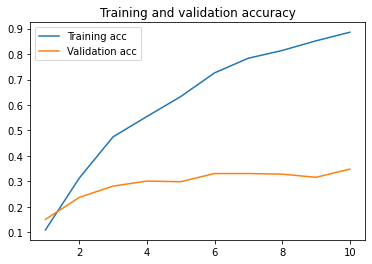

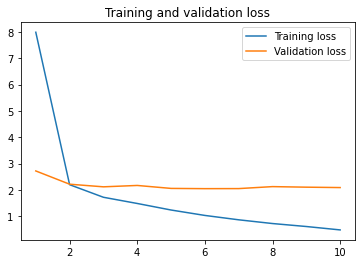

In [48]:
loss = history.history["loss"]
acc = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()